In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os

In [2]:
# Look into the data directory
# first, generate figure.
data_dir = r'M:\cs230_project\virufy_small_dataset_2s'
#print(os.listdir(data_dir))

#Training data directory
train_dir = (data_dir + '/train')
print('Classes:')
print(os.listdir(train_dir))

#Test data directory
test_dir = (data_dir + '/test')

Classes:
['detectable', 'nondetectable']


In [3]:
# create the datasets

In [4]:
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset

In [49]:
#Transformations aplied to test DS.
train_tf = tt.Compose([ tt.Grayscale(num_output_channels = 1),         
    tt.ColorJitter(brightness=0),
    tt.Resize(size=(150,150)),
    tt.RandomRotation(3),
    tt.ToTensor(),            
])

#Transformations aplied to test DS.
test_tf= tt.Compose([   tt.Grayscale(num_output_channels = 1), 
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

In [50]:
train_ds = ImageFolder(train_dir,train_tf)
test_ds = ImageFolder(test_dir,test_tf)

len(train_ds), len(test_ds)

(1938, 484)

In [51]:
img,label=train_ds[0]
img.shape

torch.Size([1, 150, 150])

In [52]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))
    

In [53]:
print('Training dataset information:')
ds_info(train_ds)

Training dataset information:
Size of the dataset:1938
Number of classes:2
Samples for every class:
detectable : 996
nondetectable : 942


In [54]:
print('Test dataset information:')
ds_info(test_ds)


Test dataset information:
Size of the dataset:484
Number of classes:2
Samples for every class:
detectable : 249
nondetectable : 235


In [55]:
batch_size = 254

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=3,
    shuffle=False,
    pin_memory=True
)

In [56]:
from torchvision.utils import make_grid

In [57]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

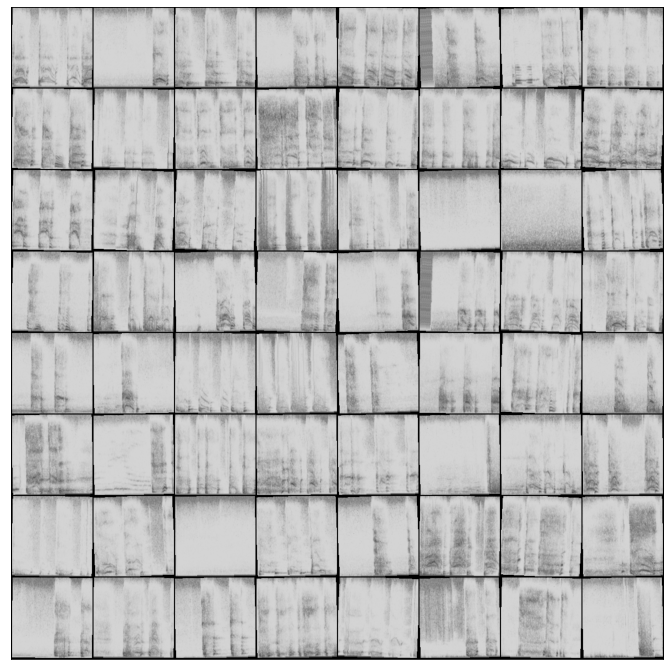

In [58]:
%matplotlib inline
show_batch(train_dl)

In [59]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [60]:
device = get_default_device() #Getting the device
device

train_dl = DeviceDataLoader(train_dl, device) #Transfering train data to GPU
test_dl = DeviceDataLoader(test_dl, device)   #Transfering test data to GPU

In [61]:
# create network

In [62]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [64]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['train_acc'],result['val_loss'], result['val_acc']))

In [65]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        self.dropout = nn.Dropout(0)
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.dropout(out)
        
        out = self.res1(out) + out
        out = self.dropout(out)
        
        out = self.conv3(out)
        out = self.dropout(out)
        
        out = self.conv4(out)
        out = self.dropout(out)
        
        out = self.res2(out) + out
        out = self.dropout(out)
        
        out = self.classifier(out)
        
        return out

In [66]:
from tqdm.notebook import tqdm

In [67]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_acces = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)['train_loss']
            acc = model.training_step(batch)['train_acc']
            train_losses.append(loss)
            train_acces.append(acc)
            loss.backward()

            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acces).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [68]:
def plot_scores(history):
    train_acc = [x.get('train_acc') for x in history]
    val_scores = [x['val_acc'] for x in history]
    plt.plot(train_acc,'-bx')
    plt.plot(val_scores, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylabel(['Training','Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [69]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [70]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,test_ds.classes[preds[0].item()])

In [71]:
#ResNet9

In [72]:
model = to_device(ResNet9(1,2), device) # two classes 0 and 1
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [73]:
history = [evaluate(model, test_dl)]
history

[{'val_loss': 0.692980945110321, 'val_acc': 0.5098425149917603}]

In [74]:
epochs = 200
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [75]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00004, train_loss: 0.8026,train_acc: 0.4980, val_loss: 0.7148, val_acc: 0.4902


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00004, train_loss: 0.7220,train_acc: 0.5160, val_loss: 0.6940, val_acc: 0.5009


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00005, train_loss: 0.7100,train_acc: 0.5301, val_loss: 0.7003, val_acc: 0.5147


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00005, train_loss: 0.6794,train_acc: 0.5699, val_loss: 0.6910, val_acc: 0.5115


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00006, train_loss: 0.6710,train_acc: 0.5942, val_loss: 0.6935, val_acc: 0.5445


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00006, train_loss: 0.6638,train_acc: 0.6023, val_loss: 0.6992, val_acc: 0.5061


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00007, train_loss: 0.6588,train_acc: 0.6077, val_loss: 0.6953, val_acc: 0.5789


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00008, train_loss: 0.6548,train_acc: 0.5987, val_loss: 0.6901, val_acc: 0.5551


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00009, train_loss: 0.6403,train_acc: 0.6268, val_loss: 0.7098, val_acc: 0.5059


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00010, train_loss: 0.6411,train_acc: 0.6391, val_loss: 0.6901, val_acc: 0.5945


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00012, train_loss: 0.6261,train_acc: 0.6510, val_loss: 0.6897, val_acc: 0.5672


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00013, train_loss: 0.6124,train_acc: 0.6658, val_loss: 0.6992, val_acc: 0.5508


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00015, train_loss: 0.5983,train_acc: 0.6757, val_loss: 0.7028, val_acc: 0.5559


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00016, train_loss: 0.5908,train_acc: 0.6781, val_loss: 0.6980, val_acc: 0.5727


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00018, train_loss: 0.5738,train_acc: 0.7031, val_loss: 0.7731, val_acc: 0.5454


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00020, train_loss: 0.5480,train_acc: 0.7285, val_loss: 0.7422, val_acc: 0.5643


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00022, train_loss: 0.5289,train_acc: 0.7399, val_loss: 1.0303, val_acc: 0.5210


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00024, train_loss: 0.4874,train_acc: 0.7744, val_loss: 0.7918, val_acc: 0.5453


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00026, train_loss: 0.4365,train_acc: 0.7980, val_loss: 1.0791, val_acc: 0.5299


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00028, train_loss: 0.4022,train_acc: 0.8225, val_loss: 0.8230, val_acc: 0.5840


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00030, train_loss: 0.3797,train_acc: 0.8397, val_loss: 0.9828, val_acc: 0.5802


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00032, train_loss: 0.3388,train_acc: 0.8577, val_loss: 1.5115, val_acc: 0.5121


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00035, train_loss: 0.3287,train_acc: 0.8590, val_loss: 1.1249, val_acc: 0.5510


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00037, train_loss: 0.2685,train_acc: 0.8898, val_loss: 1.4490, val_acc: 0.5666


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00039, train_loss: 0.2519,train_acc: 0.8916, val_loss: 1.0719, val_acc: 0.6206


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00042, train_loss: 0.2247,train_acc: 0.9069, val_loss: 0.9948, val_acc: 0.5970


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00044, train_loss: 0.2304,train_acc: 0.9046, val_loss: 1.3127, val_acc: 0.5602


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00047, train_loss: 0.2289,train_acc: 0.9132, val_loss: 1.0665, val_acc: 0.6281


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00049, train_loss: 0.1677,train_acc: 0.9394, val_loss: 1.4180, val_acc: 0.5532


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00052, train_loss: 0.1312,train_acc: 0.9537, val_loss: 1.1067, val_acc: 0.5753


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00054, train_loss: 0.1512,train_acc: 0.9391, val_loss: 1.2104, val_acc: 0.5831


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00057, train_loss: 0.1559,train_acc: 0.9369, val_loss: 1.4710, val_acc: 0.5575


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00059, train_loss: 0.1339,train_acc: 0.9495, val_loss: 1.1237, val_acc: 0.5604


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00062, train_loss: 0.1020,train_acc: 0.9665, val_loss: 1.6886, val_acc: 0.5486


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00064, train_loss: 0.1188,train_acc: 0.9518, val_loss: 3.0344, val_acc: 0.4792


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00067, train_loss: 0.1000,train_acc: 0.9607, val_loss: 2.7206, val_acc: 0.5360


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00069, train_loss: 0.1152,train_acc: 0.9574, val_loss: 3.1217, val_acc: 0.5244


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00071, train_loss: 0.1062,train_acc: 0.9576, val_loss: 1.5694, val_acc: 0.5521


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00074, train_loss: 0.0977,train_acc: 0.9665, val_loss: 1.4498, val_acc: 0.5903


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00076, train_loss: 0.0766,train_acc: 0.9723, val_loss: 2.1809, val_acc: 0.5265


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00078, train_loss: 0.1020,train_acc: 0.9644, val_loss: 1.8403, val_acc: 0.5460


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00080, train_loss: 0.1262,train_acc: 0.9523, val_loss: 1.2221, val_acc: 0.5476


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00082, train_loss: 0.0590,train_acc: 0.9805, val_loss: 1.2465, val_acc: 0.5653


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00084, train_loss: 0.0375,train_acc: 0.9852, val_loss: 1.6663, val_acc: 0.5570


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00086, train_loss: 0.0388,train_acc: 0.9866, val_loss: 1.6453, val_acc: 0.5682


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00088, train_loss: 0.0385,train_acc: 0.9886, val_loss: 3.4570, val_acc: 0.5250


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00089, train_loss: 0.0975,train_acc: 0.9596, val_loss: 3.9010, val_acc: 0.5067


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00091, train_loss: 0.1701,train_acc: 0.9306, val_loss: 1.2470, val_acc: 0.5702


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00092, train_loss: 0.0812,train_acc: 0.9718, val_loss: 1.4521, val_acc: 0.5618


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00094, train_loss: 0.0668,train_acc: 0.9747, val_loss: 1.4049, val_acc: 0.5832


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00095, train_loss: 0.0638,train_acc: 0.9803, val_loss: 1.8168, val_acc: 0.5798


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00096, train_loss: 0.0789,train_acc: 0.9686, val_loss: 1.5394, val_acc: 0.5765


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00097, train_loss: 0.0547,train_acc: 0.9769, val_loss: 2.5010, val_acc: 0.5475


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00098, train_loss: 0.0332,train_acc: 0.9904, val_loss: 2.6526, val_acc: 0.5170


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00098, train_loss: 0.0530,train_acc: 0.9824, val_loss: 2.2475, val_acc: 0.5275


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00099, train_loss: 0.0446,train_acc: 0.9836, val_loss: 3.5392, val_acc: 0.5155


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00099, train_loss: 0.0415,train_acc: 0.9849, val_loss: 1.7128, val_acc: 0.5641


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00100, train_loss: 0.0289,train_acc: 0.9897, val_loss: 2.0556, val_acc: 0.5588


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00100, train_loss: 0.0711,train_acc: 0.9731, val_loss: 4.7067, val_acc: 0.5194


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00100, train_loss: 0.0963,train_acc: 0.9684, val_loss: 1.9398, val_acc: 0.5358


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00100, train_loss: 0.0461,train_acc: 0.9837, val_loss: 1.7983, val_acc: 0.5559


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00100, train_loss: 0.0187,train_acc: 0.9951, val_loss: 2.3587, val_acc: 0.5557


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00100, train_loss: 0.0189,train_acc: 0.9941, val_loss: 2.3277, val_acc: 0.5594


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00100, train_loss: 0.0240,train_acc: 0.9918, val_loss: 1.9956, val_acc: 0.5632


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00100, train_loss: 0.0215,train_acc: 0.9923, val_loss: 3.7151, val_acc: 0.5247


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00100, train_loss: 0.0147,train_acc: 0.9946, val_loss: 1.9712, val_acc: 0.5666


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00099, train_loss: 0.0060,train_acc: 0.9990, val_loss: 2.0413, val_acc: 0.5750


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00099, train_loss: 0.0082,train_acc: 0.9966, val_loss: 2.9182, val_acc: 0.5414


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00099, train_loss: 0.0051,train_acc: 0.9990, val_loss: 2.9150, val_acc: 0.5682


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70], last_lr: 0.00099, train_loss: 0.0053,train_acc: 0.9985, val_loss: 3.5112, val_acc: 0.5469


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71], last_lr: 0.00098, train_loss: 0.0112,train_acc: 0.9958, val_loss: 3.1115, val_acc: 0.5545


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72], last_lr: 0.00098, train_loss: 0.0146,train_acc: 0.9966, val_loss: 3.7853, val_acc: 0.5487


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73], last_lr: 0.00098, train_loss: 0.0079,train_acc: 0.9980, val_loss: 3.1171, val_acc: 0.5524


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74], last_lr: 0.00098, train_loss: 0.0070,train_acc: 0.9987, val_loss: 3.2244, val_acc: 0.5187


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75], last_lr: 0.00097, train_loss: 0.0065,train_acc: 0.9980, val_loss: 4.7242, val_acc: 0.5157


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76], last_lr: 0.00097, train_loss: 0.0045,train_acc: 0.9990, val_loss: 2.3430, val_acc: 0.5695


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77], last_lr: 0.00096, train_loss: 0.0034,train_acc: 0.9995, val_loss: 2.6276, val_acc: 0.5667


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78], last_lr: 0.00096, train_loss: 0.0016,train_acc: 1.0000, val_loss: 3.2827, val_acc: 0.5359


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79], last_lr: 0.00096, train_loss: 0.0031,train_acc: 0.9990, val_loss: 2.4696, val_acc: 0.5677


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80], last_lr: 0.00095, train_loss: 0.0056,train_acc: 0.9975, val_loss: 5.5400, val_acc: 0.5161


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81], last_lr: 0.00095, train_loss: 0.0054,train_acc: 0.9990, val_loss: 3.1561, val_acc: 0.5543


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82], last_lr: 0.00094, train_loss: 0.0069,train_acc: 0.9980, val_loss: 3.6376, val_acc: 0.5431


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83], last_lr: 0.00093, train_loss: 0.0039,train_acc: 0.9985, val_loss: 3.3377, val_acc: 0.5252


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84], last_lr: 0.00093, train_loss: 0.0025,train_acc: 0.9995, val_loss: 2.8077, val_acc: 0.5507


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85], last_lr: 0.00092, train_loss: 0.0081,train_acc: 0.9966, val_loss: 3.8372, val_acc: 0.5486


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86], last_lr: 0.00092, train_loss: 0.0266,train_acc: 0.9931, val_loss: 4.2930, val_acc: 0.5204


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87], last_lr: 0.00091, train_loss: 0.0288,train_acc: 0.9906, val_loss: 2.2864, val_acc: 0.5521


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88], last_lr: 0.00090, train_loss: 0.0198,train_acc: 0.9918, val_loss: 1.9281, val_acc: 0.6090


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89], last_lr: 0.00090, train_loss: 0.0208,train_acc: 0.9936, val_loss: 2.3097, val_acc: 0.5399


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90], last_lr: 0.00089, train_loss: 0.0430,train_acc: 0.9858, val_loss: 6.0480, val_acc: 0.5173


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91], last_lr: 0.00088, train_loss: 0.0357,train_acc: 0.9862, val_loss: 3.8975, val_acc: 0.5220


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92], last_lr: 0.00088, train_loss: 0.0367,train_acc: 0.9856, val_loss: 2.1065, val_acc: 0.5425


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93], last_lr: 0.00087, train_loss: 0.0408,train_acc: 0.9835, val_loss: 3.3161, val_acc: 0.5206


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94], last_lr: 0.00086, train_loss: 0.0179,train_acc: 0.9953, val_loss: 1.7728, val_acc: 0.5804


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95], last_lr: 0.00085, train_loss: 0.0117,train_acc: 0.9966, val_loss: 1.9762, val_acc: 0.5853


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96], last_lr: 0.00085, train_loss: 0.0127,train_acc: 0.9950, val_loss: 2.0859, val_acc: 0.5652


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97], last_lr: 0.00084, train_loss: 0.0072,train_acc: 0.9975, val_loss: 2.4937, val_acc: 0.5384


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98], last_lr: 0.00083, train_loss: 0.0051,train_acc: 0.9990, val_loss: 2.8180, val_acc: 0.5409


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99], last_lr: 0.00082, train_loss: 0.0040,train_acc: 0.9985, val_loss: 2.4329, val_acc: 0.5674


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100], last_lr: 0.00081, train_loss: 0.0042,train_acc: 0.9995, val_loss: 2.9213, val_acc: 0.5423


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [101], last_lr: 0.00080, train_loss: 0.0024,train_acc: 0.9995, val_loss: 2.6781, val_acc: 0.5875


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [102], last_lr: 0.00079, train_loss: 0.0011,train_acc: 1.0000, val_loss: 2.4944, val_acc: 0.5826


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [103], last_lr: 0.00078, train_loss: 0.0027,train_acc: 0.9990, val_loss: 2.5539, val_acc: 0.6060


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [104], last_lr: 0.00078, train_loss: 0.0012,train_acc: 1.0000, val_loss: 2.6207, val_acc: 0.5689


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [105], last_lr: 0.00077, train_loss: 0.0005,train_acc: 1.0000, val_loss: 2.6236, val_acc: 0.5620


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [106], last_lr: 0.00076, train_loss: 0.0004,train_acc: 1.0000, val_loss: 2.6270, val_acc: 0.5682


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [107], last_lr: 0.00075, train_loss: 0.0005,train_acc: 1.0000, val_loss: 2.6942, val_acc: 0.5663


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [108], last_lr: 0.00074, train_loss: 0.0004,train_acc: 1.0000, val_loss: 2.7098, val_acc: 0.5577


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [109], last_lr: 0.00073, train_loss: 0.0008,train_acc: 0.9995, val_loss: 2.9890, val_acc: 0.5671


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [110], last_lr: 0.00072, train_loss: 0.0004,train_acc: 1.0000, val_loss: 2.6825, val_acc: 0.5744


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [111], last_lr: 0.00071, train_loss: 0.0019,train_acc: 0.9995, val_loss: 2.9583, val_acc: 0.5720


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [112], last_lr: 0.00070, train_loss: 0.0007,train_acc: 1.0000, val_loss: 2.8124, val_acc: 0.5693


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [113], last_lr: 0.00069, train_loss: 0.0004,train_acc: 1.0000, val_loss: 2.5937, val_acc: 0.5984


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [114], last_lr: 0.00068, train_loss: 0.0003,train_acc: 1.0000, val_loss: 2.5615, val_acc: 0.5685


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [115], last_lr: 0.00067, train_loss: 0.0003,train_acc: 1.0000, val_loss: 2.6071, val_acc: 0.5607


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [116], last_lr: 0.00065, train_loss: 0.0002,train_acc: 1.0000, val_loss: 2.6411, val_acc: 0.5761


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [117], last_lr: 0.00064, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6390, val_acc: 0.5714


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [118], last_lr: 0.00063, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6640, val_acc: 0.5666


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [119], last_lr: 0.00062, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6841, val_acc: 0.5693


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [120], last_lr: 0.00061, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6556, val_acc: 0.5737


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [121], last_lr: 0.00060, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6715, val_acc: 0.5698


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [122], last_lr: 0.00059, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6505, val_acc: 0.5755


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [123], last_lr: 0.00058, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.7055, val_acc: 0.5721


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [124], last_lr: 0.00057, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6567, val_acc: 0.5674


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [125], last_lr: 0.00056, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6601, val_acc: 0.5710


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [126], last_lr: 0.00054, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6723, val_acc: 0.5672


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [127], last_lr: 0.00053, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6768, val_acc: 0.5712


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [128], last_lr: 0.00052, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6807, val_acc: 0.5724


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [129], last_lr: 0.00051, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6804, val_acc: 0.5753


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [130], last_lr: 0.00050, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6909, val_acc: 0.5690


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [131], last_lr: 0.00049, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6895, val_acc: 0.5707


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [132], last_lr: 0.00048, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6779, val_acc: 0.5785


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [133], last_lr: 0.00047, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6974, val_acc: 0.5779


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [134], last_lr: 0.00046, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6946, val_acc: 0.5757


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [135], last_lr: 0.00044, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6953, val_acc: 0.5769


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [136], last_lr: 0.00043, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6879, val_acc: 0.5735


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [137], last_lr: 0.00042, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6953, val_acc: 0.5777


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [138], last_lr: 0.00041, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6730, val_acc: 0.5801


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [139], last_lr: 0.00040, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6832, val_acc: 0.5761


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [140], last_lr: 0.00039, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6730, val_acc: 0.5769


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [141], last_lr: 0.00038, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6763, val_acc: 0.5763


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [142], last_lr: 0.00037, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.6872, val_acc: 0.5744


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [143], last_lr: 0.00036, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6782, val_acc: 0.5716


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [144], last_lr: 0.00035, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6861, val_acc: 0.5735


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [145], last_lr: 0.00033, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6876, val_acc: 0.5735


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [146], last_lr: 0.00032, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.7056, val_acc: 0.5714


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [147], last_lr: 0.00031, train_loss: 0.0001,train_acc: 1.0000, val_loss: 2.7031, val_acc: 0.5727


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [148], last_lr: 0.00030, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6955, val_acc: 0.5690


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [149], last_lr: 0.00029, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.7066, val_acc: 0.5767


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [150], last_lr: 0.00028, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.7028, val_acc: 0.5751


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [151], last_lr: 0.00027, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6853, val_acc: 0.5716


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [152], last_lr: 0.00026, train_loss: 0.0000,train_acc: 1.0000, val_loss: 2.6866, val_acc: 0.5694


  0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001F8542DA160>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


OSError: Caught OSError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 232, in __getitem__
    sample = self.loader(path)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 269, in default_loader
    return pil_loader(path)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\folder.py", line 251, in pil_loader
    return img.convert('RGB')
  File "C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py", line 904, in convert
    self.load()
  File "C:\ProgramData\Anaconda3\lib\site-packages\PIL\ImageFile.py", line 237, in load
    s = read(self.decodermaxblock)
  File "C:\ProgramData\Anaconda3\lib\site-packages\PIL\PngImagePlugin.py", line 919, in load_read
    return self.fp.read(read_bytes)
OSError: [Errno 22] Invalid argument


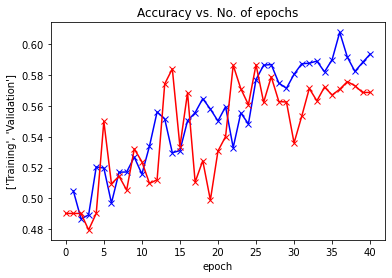

In [36]:
plot_scores(history)

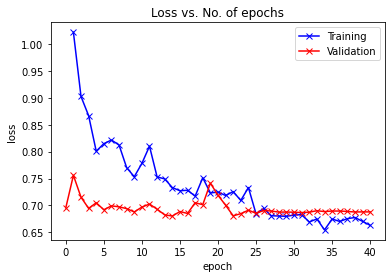

In [37]:
plot_losses(history)

In [ ]:
class model18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        self.network.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
model = to_device(model18(), device)
model

In [ ]:
history = [evaluate(model, test_dl)]
history

In [ ]:
epochs = 20
epochs2 = 20
max_lr2 = 0.00005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
model.freeze()

In [ ]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
plot_scores(history)

In [ ]:
plot_losses(history)

In [ ]:
model.unfreeze()

In [ ]:
%%time
history += fit_one_cycle(epochs2, max_lr2, model, train_dl, test_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
plot_scores(history)

In [ ]:
plot_losses(history)

In [ ]:
model